## Load left and right images

In [77]:
import os
import cv2
from tqdm import tqdm
import numpy as np
TRAINING_DIR = 'data_scene_flow/training/image_2'
left_images = []
right_images = []
for file in tqdm(os.listdir(TRAINING_DIR)):
    path = os.path.join(TRAINING_DIR, file)
    img = cv2.imread(path, 1)
    lr = file.split('_')[1].split('.')[0]
    if lr == '10':
        left_images.append(img)
    else:
        right_images.append(img)

left_images = np.array(left_images)
right_images = np.array(right_images)

assert len(left_images)==len(right_images), 'left images size and right images size are not equal.'

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 98.85it/s]


## Data Visualization

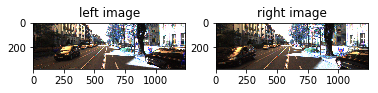

image width: 1242, image height: 375, chanel number: 3


In [78]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('left image')
ax1.imshow(left_images[0])

ax2.set_title('right image')
ax2.imshow(right_images[0])

plt.show()

img_height, img_width, chanel = left_images[0].shape
print('image width: {}, image height: {}, chanel number: {}'.format(img_width, img_height, chanel))

## Disparity Map 

In [36]:
def rgb_disparity(left_img, right_img):
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    disparity = stereo.compute(left_gray,right_gray)
    return disparity

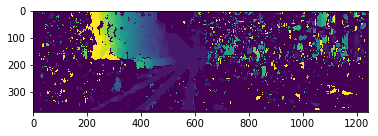

In [37]:
disparity_img = rgb_disparity(left_images[0], right_images[0])
plt.imshow(disparity_img)
plt.show()

## Use SGBM and WLS-Filter to create Disparity map
- Implement SGBM (semi-global-block-match algorithm) for left match and right match
- To obtain hole free depth-images we can use the WLS-Filter

In [86]:
def rgb_disparity_wls(left_img, right_img):
    
    # SGBM Parameters -----------------
    window_size = 3                     # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

    left_matcher = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=160,             # max_disp has to be dividable by 16 f. E. HH 192, 256
        blockSize=5,
        P1=8 * 3 * window_size ** 2,    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=0,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    # FILTER Parameters
    lmbda = 80000
    sigma = 1.2
    visual_multiplier = 1.0

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    print('computing disparity...')
    displ = left_matcher.compute(left_gray, right_gray)  # .astype(np.float32)/16
    dispr = right_matcher.compute(right_gray, left_gray)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, left_gray, None, dispr)  # important to put "imgL" here!!!
    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    filteredImg = np.uint8(filteredImg)
    return filteredImg

computing disparity...


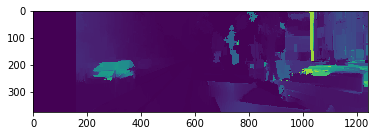

True

In [87]:
disparity_img2 = rgb_disparity_wls(left_images[0], right_images[0])
plt.imshow(disparity_img2)
plt.show()

cv2.imwrite('disparity_img2.jpg',disparity_img2)